In [1]:
import sys
sys.path.insert(0, '../')
sys.path.append('/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages') # se non carica gymnasium mettere path modulo


import gymnasium as gym
print(f"Gym Version = {gym.__version__}")

import AddictiveReward

import numpy as np

import numba as nb
from numba.experimental import jitclass

from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium import spaces
import random
from numpy.random import choice
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional

Gym Version = 0.29.1


In [2]:
env = gym.make('AddictiveEnv_v3')

### Data Plot

In [3]:
def data_plot():
    binary_data = env.unwrapped.get_statistics() 
    time_values = np.arange(len(binary_data))
    
    
    plt.figure(figsize=(16, 12))
    

    
    # Plot for total_reward
    plt.subplot(2, 2, 2)
    plt.plot(total_reward, label='Total Reward')
    plt.title('Total Reward (testing)')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.legend()
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    plt.subplot(2, 2, 4)
    plt.scatter(time_values, binary_data, marker='o', linestyle='-')
    plt.title('T Addicted Arm (Class)')
    plt.xlabel('Episode')
    plt.ylabel('Total addicted arm')
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

## AGENTE MF

In [23]:
class MFLearningAgent:
    def __init__(self, 
                 learning_rate: float,  
                 initial_epsilon: float, 
                 epsilon_decay: float,  
                 final_epsilon: float, 
                 discount_factor: float = 0.9):
        
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.training_error = []

    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values
    
    # def update_value_iteration(self, state, action, reward, next_state):
    #     old_value = self.q_values[state, action] 
    #     next_max = np.max(self.value_iteration[next_state, :])
    #     self.q_values[state, action] =  (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max) 

    def update(self, obs: int, action: int, reward: float, terminated: bool, next_obs: int):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

        
    def decay_epsilon(self):
       self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

### Test MF

In [4]:
lr = 0.01

n_episodes = 1

start_epsilon = 0.4
epsilon_decay = start_epsilon / (env.unwrapped.get_iter() / 2)  # reduce the exploration over time
final_epsilon = 0.1

env.reset_bandit()
agentMF = MFLearningAgent(
    learning_rate = lr,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
)


/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reset_bandit to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reset_bandit` for environment variables or `env.get_wrapper_attr('reset_bandit')` that will search the reminding wrappers.
  logger.warn(


In [15]:
# env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
addiction_states = []
total_reward = []
healty_states = []

t_healty_arm = []
t_addicted_arm = []
pbar = tqdm(total = env.get_iter()+1)

obs, info = env.reset()
done = False
addicted = 0
healty = 0
r = 0

healty_arm = 0
addicted_arm = 0

step = 1
# play one episode
while not done:
    action = agentMF.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    # update the agent
    agentMF.update(obs, action, reward, terminated, next_obs)
    
    # update if the environment is done and the current obs    
    if obs == 3 and next_obs == 2 and reward != 0:
        healty_arm += 1
    if obs == 3 and next_obs == 4:
        addicted_arm += 1
        
    if next_obs == 4:
        addicted += 1 
    if next_obs == 1:
        healty += 1
        
    done = terminated or truncated
    obs = next_obs
    r += reward
    
    addiction_states.append(addicted)
    total_reward.append(r)
    healty_states.append(healty)
    t_healty_arm.append(healty_arm)
    t_addicted_arm.append(addicted_arm)
    
    step += 1
    pbar.update(1)
pbar.close()

/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_iter to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_iter` for environment variables or `env.get_wrapper_attr('get_iter')` that will search the reminding wrappers.
  logger.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1051/1051 [00:00<00:00, 23211.02it/s]


In [16]:
agentMF.q_values[3]

array([0.10710238, 0.10513657, 0.06949045, 0.11869309, 1.46060005])

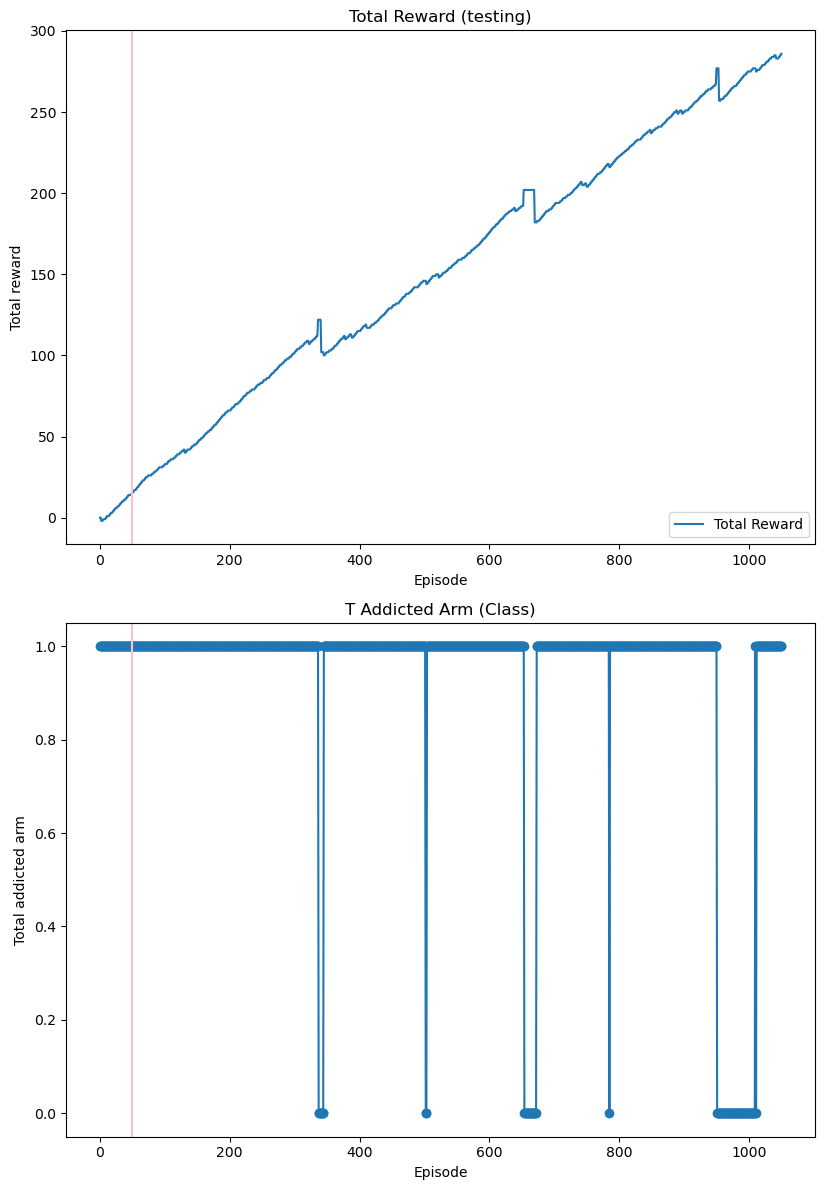

In [19]:
data_plot()

## AGENTE MB

### Classes

In [5]:
import heapq
class PriorityQueue:
    def __init__(self):
        self._queue = []
        self._index = 0

    def is_empty(self):
        if self._queue  == []:
            return True
        return False
        
    def insert(self, item, priority):
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def clean(self):
        self._queue = []
        self.index = 0
        
    def pop(self):
        return heapq.heappop(self._queue)[-1]

#### GPU test ####

In [6]:
def transition_model_to_numpy(transition_model, obs_space, action_space):
    transition_array = np.zeros((obs_space, action_space, obs_space, 3))  # Assuming 3 fields: count, probability, reward
    
    for state in range(1, obs_space):
        for action in range(action_space):
            for next_state in range(1, obs_space):
                transition_info = transition_model[state][action].get(next_state, {'count': 0, 'probability': 0, 'reward': 0})
                transition_array[state, action, next_state] = [transition_info.get('count', 0), transition_info.get('probability', 0), transition_info.get('reward', 0)]

    #print(transition_array)
    return transition_array



@nb.jit
def value_iteration_gpu(iterations, obs_space, action_space, transition_model, discount_factor, q_values):
    epsilon = 0.1
    delta = 1.0  # Set an initial value for delta
    
    while iterations > 0 and delta > epsilon:
        delta = 0
        
        for state in range(1, obs_space):
            for action in range(action_space):
                t = 0
                for next_state in range(1, obs_space):
                    count, probability, reward = transition_model[state, action, next_state]
                    t += probability * (reward + discount_factor * np.max(q_values[next_state]))
                q_values[state, action] = t
            
                # Calculate delta
                Vs = abs(q_values[state, action] - np.max(q_values[state]))
                delta = max(delta, Vs)
        
        iterations -= 1  # Decrease the number of iterations
    
    return q_values

#### mb agent

In [29]:
class MBLearningAgent:
    def __init__(self, learning_rate: float, initial_epsilon: float, epsilon_decay: float, final_epsilon: float, discount_factor: float = 0.9, mbus = 50 ,theta=0.01):
        
        
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.mbus = mbus
        self.transition_model = {} 
        self.initialize_transition_model()
        
        self.training_error = []
        
        self.pred_queue = PriorityQueue()
        self.theta = theta 
        self.upd = 0
    
    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values

    def value_iteration(self, iter):
        epsilon = 0.1
        for _ in range(1, iter):
            delta = 0
            for state in range(1, env.observation_space.n):
                for action in range(0,  env.action_space.n):
                    t = 0
                    for next_state in self.transition_model[state][action]:
                        probability = self.transition_model[state][action][next_state]['probability']
                        reward = self.transition_model[state][action][next_state]['reward']
                        t += probability * (reward + self.discount_factor * np.max(self.q_values[next_state]))
                    self.q_values[state][action] = t
                     
                Vs = abs(self.q_values[state][action] - np.max(self.q_values[state]))
                delta = max(delta, Vs)
                
            if delta < epsilon and delta > 0:
                break

    def prioritized_sweeping(self, state, action):
        self.calculate_sweep(state, action)
        while not (self.pred_queue.is_empty()):
            if self.upd > self.mbus:
                #print("stopped")
                self.pred_queue.clean()
                break
            state = self.pred_queue.pop()
                        
            for state_p in range(1, env.observation_space.n):
                for action_p in range(env.action_space.n): 
                    for next_state_p in self.transition_model[state_p][action_p]:
                        if next_state_p == state:
                            self.calculate_sweep(state_p, action_p)
                            

    def calculate_sweep(self, state, action):
        old_q = self.q_values[state][action]
        new_q = 0
        
        for next_state in self.transition_model[state][action]:
            probability = self.transition_model[state][action][next_state]['probability']
            reward = self.transition_model[state][action][next_state]['reward']
            new_q += probability * (reward + self.discount_factor * np.max(self.q_values[next_state]))
        self.q_values[state][action] = new_q
        p = abs(new_q - old_q)
        if p > 0:
            self.upd += 1
            max_q = np.max(self.q_values[state])
            if old_q == max_q or new_q == max_q:
                 self.pred_queue.insert(state, p)
       
    def initialize_transition_model(self):
        for state in range(1, env.observation_space.n):
            self.transition_model[state] = {}
            for action in range(env.action_space.n):
                self.transition_model[state][action] = {}
                for next_state in range(env.observation_space.n):
                    self.transition_model[state][action][next_state] = {'count': 0, 'probability': 0, 'reward': 0}
                    
    def update_transition_model(self, state, action, next_state, reward):
        self.transition_model[state][action][next_state]['count'] += 1
        self.transition_model[state][action][next_state]['reward'] = reward
        self.calculate_transition_probabilities()
        
        #self.prioritized_sweeping(obs, action)
        
        transition_array = transition_model_to_numpy(self.transition_model, env.observation_space.n, env.action_space.n)
        self.q_values = value_iteration_gpu(self.mbus, env.observation_space.n, env.action_space.n, transition_array, self.discount_factor, self.q_values)
        
        #self.value_iteration(self.mbus)
        
    def calculate_transition_probabilities(self):
        
        for state in range(1, env.observation_space.n):
            for action in range(env.action_space.n):
                total_count = sum(self.transition_model[state][action][next_state]['count'] for next_state in self.transition_model[state][action])
                for next_state in self.transition_model[state][action]:
                    
                    c = self.transition_model[state][action][next_state]['count']
                    if total_count == 0:
                        total_count = 1
                    self.transition_model[state][action][next_state]['probability'] = c / total_count
                    #if  self.transition_model[state][action][next_state]['probability'] != 0:
                    #    print(f"{state} {action} {next_state} { self.transition_model[state][action][next_state]['probability']}")
    
    def decay_epsilon(self):
       self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    

### Test MB

In [31]:
lr = 0.01
n_episodes = 1

start_epsilon = 0.4
epsilon_decay = start_epsilon / (env.get_iter() / 2)  # reduce the exploration over time
final_epsilon = 0.1

env.unwrapped.reset_bandit()
agentMB = MBLearningAgent(
    learning_rate = lr,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
    mbus = 15
)

In [32]:
addiction_states = []
total_reward = []
healty_states = []

t_healty_arm = []
t_addicted_arm = []
pbar = tqdm(total = env.get_iter() + 1)

obs, info = env.reset()

done = False
addicted = 0
healty = 0
r = 0

healty_arm = 0
addicted_arm = 0

step = 1
# play one episode
while not done:
    action = agentMB.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    # update the agent
    agentMB.update_transition_model(obs, action, next_obs, reward)
    
    # update if the environment is done and the current obs    
    if obs == 3 and next_obs == 2 and reward != 0:
        healty_arm += 1
    if obs == 3 and next_obs == 4:
        addicted_arm += 1
    if next_obs == 4:
        addicted += 1 
    if next_obs == 1:
        healty += 1
        
    done = terminated or truncated
    obs = next_obs
    r += reward

    agentMB.decay_epsilon()
    
    addiction_states.append(addicted)
    total_reward.append(r)
    healty_states.append(healty)
    t_healty_arm.append(healty_arm)
    t_addicted_arm.append(addicted_arm)
    
    step += 1
    pbar.update(1)
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5051/5051 [00:01<00:00, 4772.07it/s]


In [33]:
agentMB.transition_model[3][4]

{0: {'count': 0, 'probability': 0.0, 'reward': 0},
 1: {'count': 0, 'probability': 0.0, 'reward': 0},
 2: {'count': 4, 'probability': 0.03773584905660377, 'reward': -2},
 3: {'count': 0, 'probability': 0.0, 'reward': 0},
 4: {'count': 102, 'probability': 0.9622641509433962, 'reward': 10}}

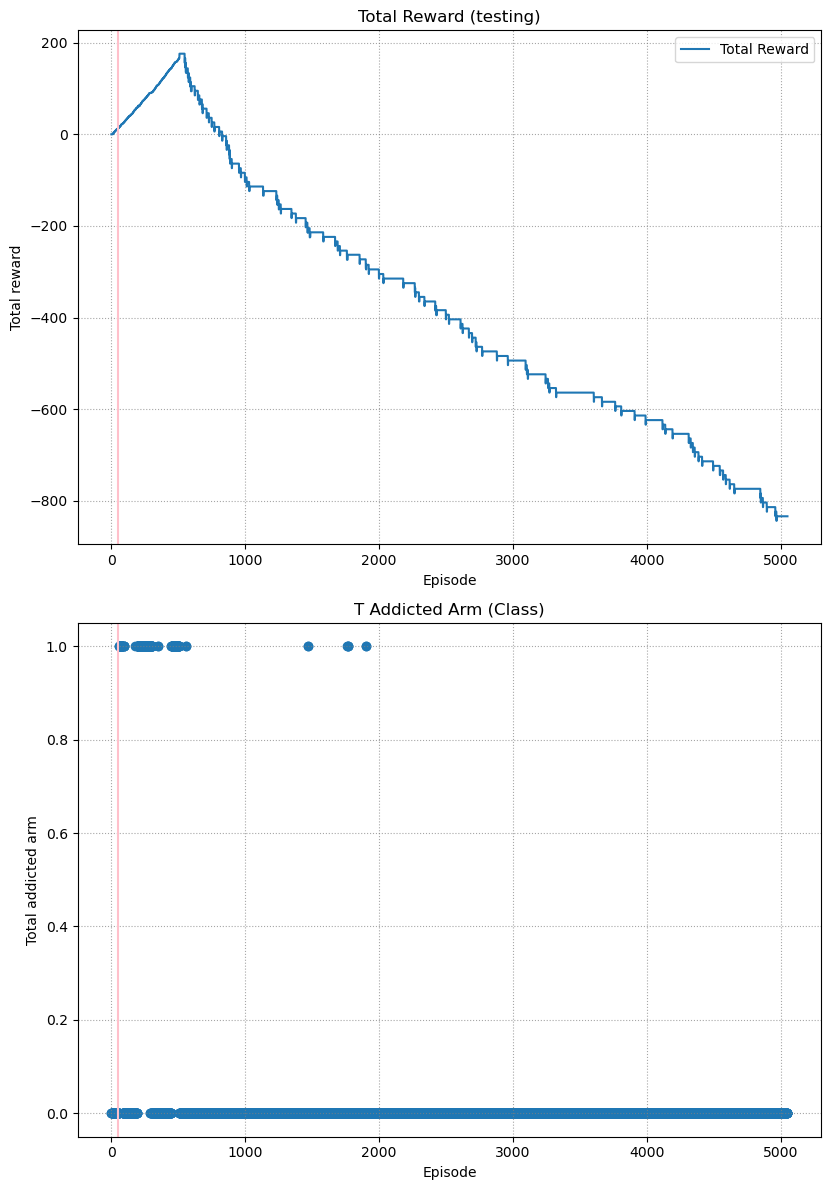

In [34]:
data_plot()

## MX Agent ##

In [25]:
class MXLearningAgent:
    def __init__(self, lr, ie, ed, fe, Beta, Epsilon, MBUS):
        self.MF_agent = MFLearningAgent(
                            learning_rate = lr,
                            initial_epsilon = ie,
                            epsilon_decay = ed,
                            final_epsilon = fe,
                        )
        self.MB_agent = MBLearningAgent(
                            learning_rate = lr,
                            initial_epsilon = ie,
                            epsilon_decay = ed,
                            final_epsilon = fe,
                            mbus = MBUS
                        )
        self.beta = Beta
        self.epsilon = Epsilon
    
    def get_action(self, state):
        if random.uniform(0, 1) > self.epsilon:
            if random.uniform(0, 1) < self.beta: # Beta 1 = MB || Beta = 0 = MF
                return np.argmax(self.MB_agent.q_values[state]) # Explore action space
            else:
                return np.argmax(self.MF_agent.q_values[state])  # Exploit learned values  
        else:
            return env.action_space.sample()
            
    def update(self, obs, action, reward, terminated, next_obs):
        self.MF_agent.update(obs, action, reward, terminated, next_obs)
        self.MF_agent.decay_epsilon()
        self.MB_agent.update_transition_model(obs, action, next_obs, reward)
        self.MB_agent.decay_epsilon()
        

In [26]:
lr = 0.01
n_episodes = 1

ie = 0.4
ed = ie / (env.get_iter() / 2)  # reduce the exploration over time
fe = 0.1

beta = 0

agentMX = MXLearningAgent(
    lr = lr,
    ie = ie,
    ed = ed,
    fe = fe,
    Beta = beta,
    Epsilon = 0.1,
    MBUS = 10,
)


env.unwrapped.reset_bandit()
addiction_states = []
total_reward = []

In [30]:

pbar = tqdm(total = env.get_iter()+1)
#for episode in tqdm(range(n_episodes)):
obs, info = env.reset()
done = False
addicted = 0
r = 0

while not done:
    action = agentMX.get_action(obs)
    
    next_obs, reward, terminated, truncated, info = env.step(action)
    
    agentMX.update(obs, action, reward, terminated, next_obs)
    #agentMB.prioritized_sweeping(obs, action, 10000)
    
    done = terminated or truncated
    obs = next_obs
    r += reward
    if obs == 4:
        addicted += 1 
    pbar.update(1)
    addiction_states.append(addicted)
    total_reward.append(r)
    
pbar.close()



  5%|████▌                                                                                            | 50/1051 [02:34<51:41,  3.10s/it]


KeyError: 4

In [12]:
agentMX.MB_agent.q_values


array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [4.73684211, 4.73684211, 5.26315789, 4.73684211, 4.73684211],
       [4.26315789, 3.83684211, 4.73684211, 4.26315789, 4.26315789],
       [4.26315789, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

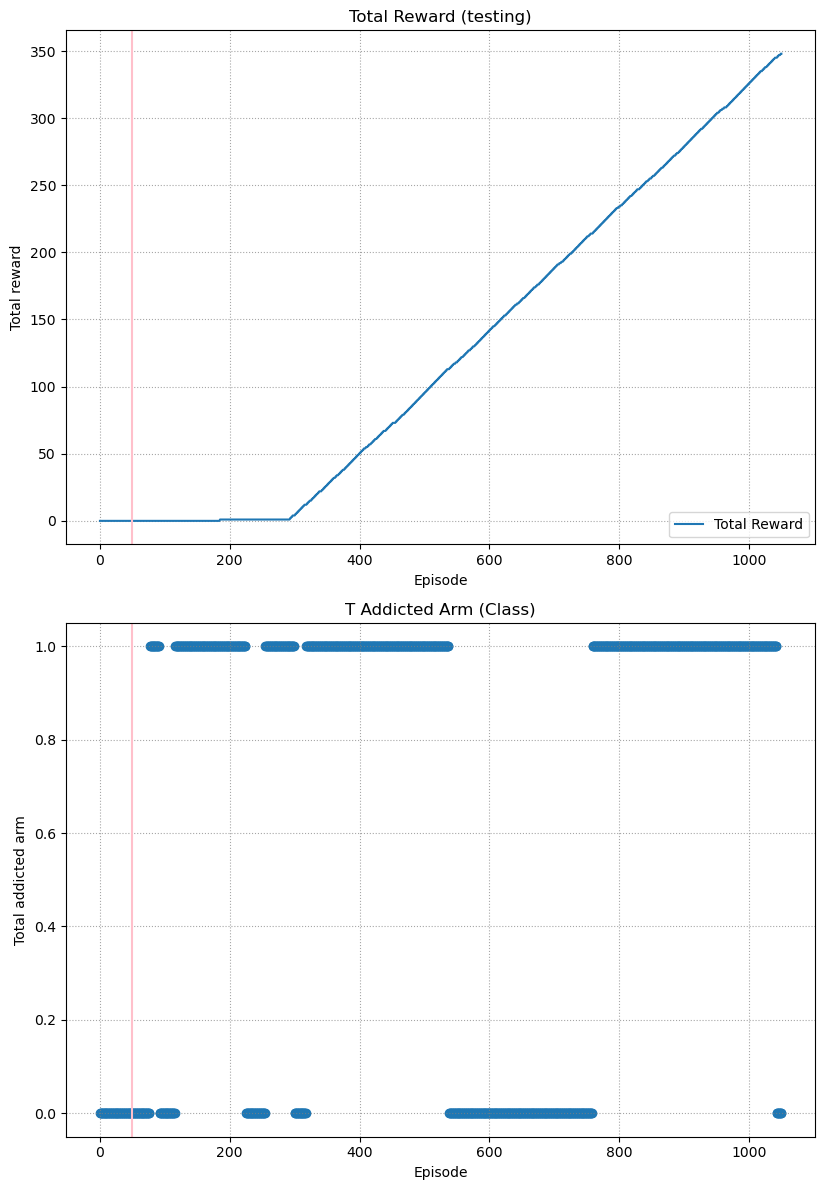

In [11]:
data_plot()

## Multi agent test ##

In [33]:
# agenti
agents = []
addiction_states = []

# parametri
lr = 0.01
n_episodes = 50
se = 0.1
# creazione 900 agenti
print("creazione agenti")
nagenti = 5

for _ in range(nagenti):
    agent = MBLearningAgent(
        learning_rate = lr,
        initial_epsilon = se,
    )
    agents.append(agent)
    
print("agenti creati")

#timesteps
print("calcolo")

T = 25
#means, stds Addited
meansA = []
stdsA =  []
#means, stds Healthy
meansH = []
stdsH = []

for i in range(T):
    n = 1
    
    #percs Addicted and Healthy
    percsA = []
    percsH = []
    for agent in agents:
        obs, info = env.reset()
        done = False
        addicted = 0
        healthy = 0
        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)


            
            #conto stati
            if(next_obs == 4):
                addicted = addicted + 1
            if(next_obs == 1):
                healthy = healthy + 1
            
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
       
        #print(f"agente {n} healthy {healthy}")
        #print(f"agente {n} addicted {addicted}")
        #perc Addicted and Healthy
        percA = (addicted / (addicted + healthy))
        percH = (healthy / (addicted + healthy))
        #print(perc)
        percsA.append(percA)
        percsH.append(percH)
        n = n + 1
        
    #addicted
    meanA = np.mean(percsA)
    stdA = np.std(percsA)
    meansA.append(meanA)
    stdsA.append(stdA)

    addiction_states.append(meanA)
    #healthy
    meanH = np.mean(percsH)
    stdH = np.std(percsH)
    meansH.append(meanH)
    stdsH.append(stdH)

#addicted
print(meansA)
print(stdsA)

#healthy
print(meansH)
print(stdsH)

creazione agenti
agenti creati
calcolo
[0.0, 0.023076923076923078, 0.14369663433450705, 0.06379897185952112, 0.0, 0.03578595317725752, 0.0, 0.00899795501022495, 0.0, 0.0, 0.0, 0.001873144399460189, 0.02369534555712271, 0.07412173525230659, 0.0, 0.0, 0.0038399999999999997, 0.02824074074074074, 0.0, 0.04386556547789573, 0.10984615384615384, 0.0, 0.0, 0.021837088388214902, 0.0]
[0.0, 0.046153846153846156, 0.14979470383463292, 0.05625528755015832, 0.0, 0.07157190635451505, 0.0, 0.0179959100204499, 0.0, 0.0, 0.0, 0.002614803794403106, 0.04739069111424542, 0.09566716729806915, 0.0, 0.0, 0.00768, 0.05648148148148148, 0.0, 0.07057539140187123, 0.17303156860638252, 0.0, 0.0, 0.043674176776429804, 0.0]
[1.0, 0.976923076923077, 0.8563033656654928, 0.9362010281404789, 1.0, 0.9642140468227425, 1.0, 0.9910020449897751, 1.0, 1.0, 1.0, 0.9981268556005398, 0.9763046544428773, 0.9258782647476934, 1.0, 1.0, 0.99616, 0.9717592592592592, 1.0, 0.9561344345221041, 0.8901538461538461, 1.0, 1.0, 0.978162911611

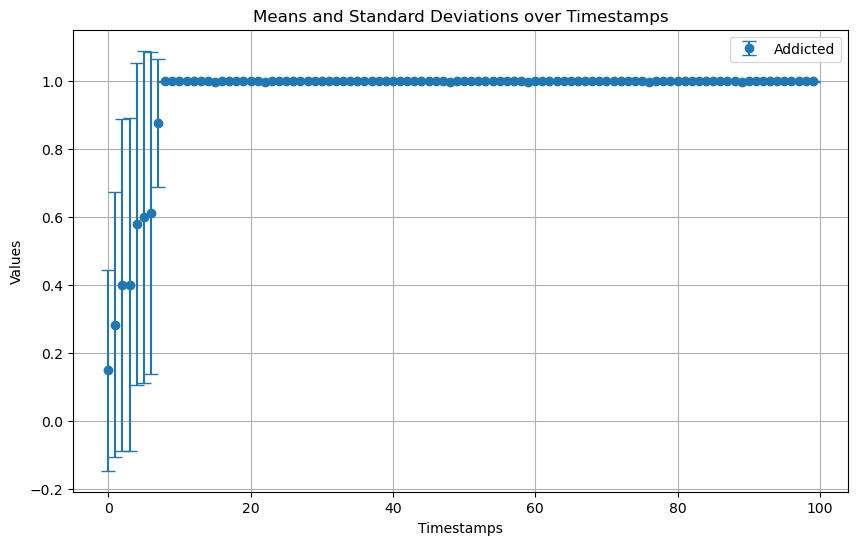

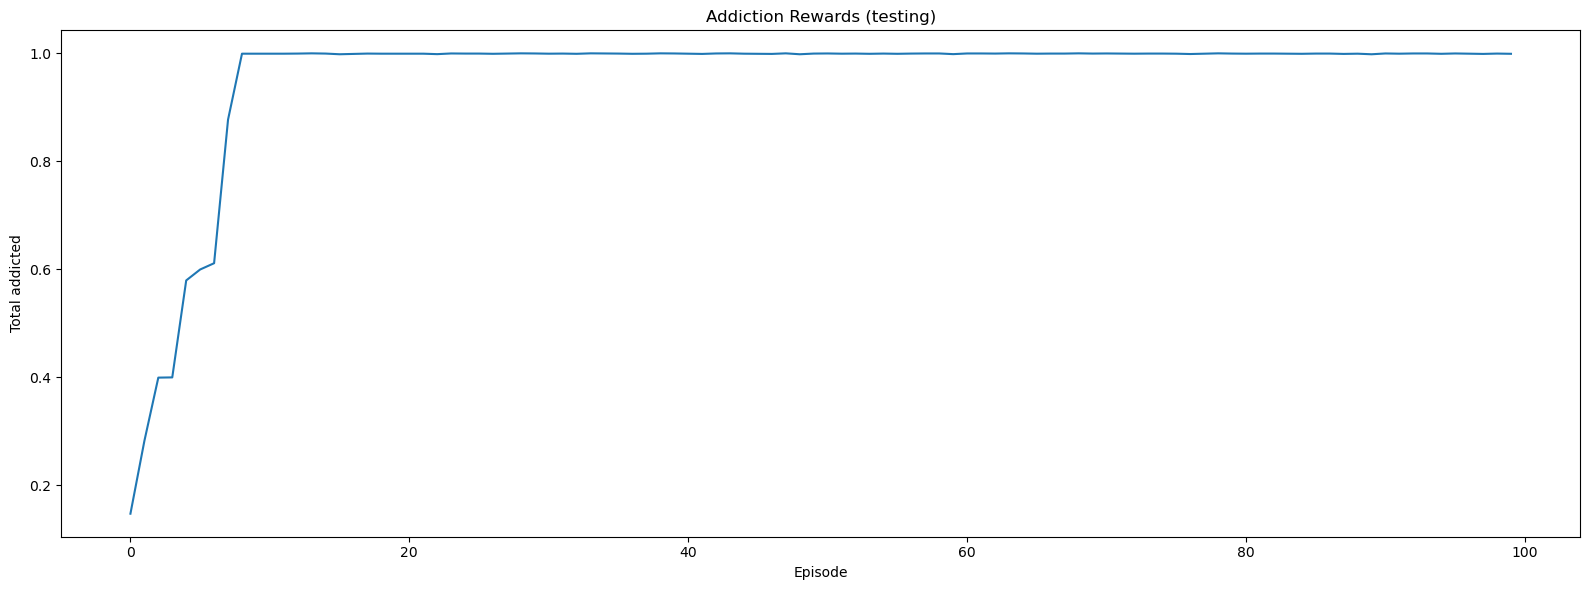

In [42]:
#plot
#print(sys.getsizeof(stds))
timestamps = np.arange(T)
plt.figure(figsize=(10, 6))
plt.errorbar(timestamps, meansA, yerr=stdsA, fmt='o', capsize=5, label='Addicted')
#plt.errorbar(timestamps, meansH, yerr=stdsH, fmt='o', capsize=5, label='Healthy', color='pink')
plt.xlabel('Timestamps')
plt.ylabel('Values')
plt.title('Means and Standard Deviations over Timestamps')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(addiction_states)
plt.title('Addiction Rewards (testing)')
plt.xlabel('Episode')
plt.ylabel('Total addicted')
plt.tight_layout()
plt.show()